In [21]:
import psycopg2
import sys
sys.path.append('/Users/kshain/Documents/Git')
from progressbar import ProgressBar
import sqlalchemy
import pandas.io.sql as psql
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
% matplotlib inline
import scipy
import pandas as pd
from scipy.optimize import curve_fit

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# Play-by-play Free Throw Analysis

## Table of contents
* [Connecting to the Database](#Connecting-to-the-Database)
* [Data Exploration](#Data-Exploration)
    * [Historical Free Throw Analysis](#Historical-Free-Throw-Analysis)
    * [FT percentage as a function of gametime](#FT-percentage-as-a-function-of-gametime)
    * [Gametime dependence by player](#Gametime-dependence-by-player)
    * [Effect of years in the league](#Effect-of-years-in-the-league)
    * [Effect of free throw number](#Effect-of-free-throw-number)
* [Free Throw Prediction](#Free-Throw-Prediction)
    * [Obeying the flow of time](#Obeying-the-flow-of-time)
    * [The log loss metric](#The-log-loss-metric)
    * [Feature standardization](#Feature-standardization)
    * [Making predictions](#Making-predictions)
* [Conclusion](#Conclusion)
* [Future directions](#Future-directions)

## Connecting to the Database

The database was assembled by `DataScrape.ipynb`.

In [2]:
conn = None

try:
    conn_string = "host='localhost',database='freethrows', user='kshain'"
    print('Connecting to database\n ->',conn_string)
    conn = psycopg2.connect(host='localhost',database='freethrows', user='kshain') 
    cur = conn.cursor()
    print('Connected!\n')            

except psycopg2.DatabaseError:
    print ('Error')  
    sys.exit(1)

Connecting to database
 -> host='localhost',database='freethrows', user='kshain'
Connected!



In [3]:
engine = sqlalchemy.create_engine('postgresql://kshain@localhost:5432/freethrows')

## Data Exploration

### Historical Free Throw Analysis

To confirm the general integrity of the data, I'll repeat some of the very macroscopic analyses that appear in popular news stories. First, I confirm that the overall average free throw percentage is around 75%.

In [8]:
query = "SELECT SUM(ft)/SUM(fta)*100 as alltime_avg_ft_pct FROM seasontotals"
psql.read_sql(query, conn) 

,alltime_avg_ft_pct
0,74.897873


Next, I'll make sure that it doesn't vary much over time and reaches a maximum of 77.1% in 1974.

In [10]:
query = "SELECT year, SUM(ft)/SUM(fta)*100 as avg_ft_pct FROM seasontotals GROUP BY year ORDER BY year ASC"
avgByYear = psql.read_sql(query, conn) 
avgByYear

,year,avg_ft_pct
0,1950,71.248957
1,1951,73.336719
2,1952,73.484641
3,1953,71.590322
4,1954,70.874784
5,1955,73.700929
6,1956,74.521973
7,1957,75.098684
8,1958,74.648590
9,1959,75.607423


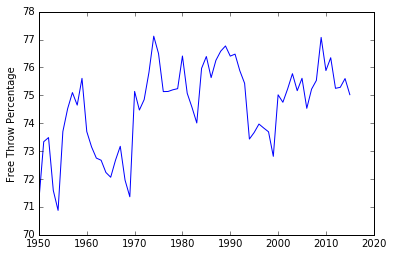

In [12]:
plt.plot(avgByYear.year, avgByYear.avg_ft_pct)
plt.ylabel('Free Throw Percentage')

### FT percentage as a function of gametime

The premise of this exploration as a whole is to get a sense of which features correlate with free throw percentage. Even a few that do would be interesting as people currently only consider season or career averages. Gametime seems like it could have some impact on free throw percentage. As a whole, the best players are more likely to play in the first and fourth quarters and rest sometime during the middle of the game. One could imagine that players get warmed up during the course of the game, but they might also get tired near the end. Overall, there will be a lot of correlated factors so it is impossible to get causal relationships, but observing trends is a start. At this point, we are getting into analyses that could not be done without play-by-play data. 

In [13]:
query = "SELECT FLOOR(gametime) as gametime, AVG(result) as ftpct FROM pbpfts GROUP BY FLOOR(gametime) ORDER BY FLOOR(gametime) ASC"
gametimeresults = psql.read_sql("SELECT FLOOR(gametime) as gametime, AVG(result) as ftpct FROM pbpfts GROUP BY FLOOR(gametime) ORDER BY FLOOR(gametime) ASC", conn)

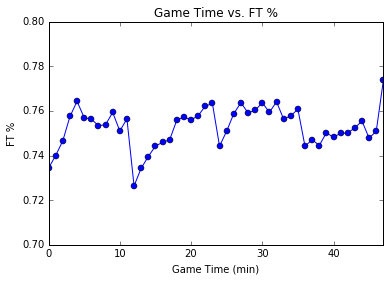

In [14]:
plt.plot(gametimeresults.gametime, gametimeresults.ftpct, '-o')
plt.xlim((0,47))
plt.ylim((.7,.8))
plt.title('Game Time vs. FT %')
plt.xlabel('Game Time (min)')
plt.ylabel('FT %')

As we can see, the most obvious feature of the plot is that the free throw percentage is lower at the beginning of each quarter. Perhaps this indicates that players are more likely to be cold after sitting, but we definitely have to control for the players shooting the free throws. It is particularly true that substitutes tend to play at the beinning of the second quarter. Also, we see a rise in the free throw percentage in the last minute of the game. This should not be entirely surprising since teams intentionally play there best free throw shooters at the end of the game when the other team is in a position to foul.

### Gametime dependence by player

We want to control for whether the gametime dependence is really a manifestation of different players being on the court. To do this, I will calculate an average free throw percentage at each minute of the game, but instead of averaging over all free throws attempted, I will average all the players' free throw percentages. In this way, the same players are all weighted equally no matter how many free throws they attempt at a given gametime. Just to not include players who shoot extremely few free throws, I am only averaging over the top 200 shooters by volume.

In [17]:
query = "SELECT player, count(result) as FTs FROM pbpfts GROUP BY player ORDER BY count(result) DESC LIMIT  100"
topshooters = psql.read_sql(query, conn)
topshooters.head(10)

,player,fts
0,K. Bryant,9547
1,L. James,9422
2,P. Pierce,8617
3,J. Smith,8418
4,T. Duncan,8257
5,D. Howard,8212
6,D. Nowitzki,8207
7,D. Wade,7463
8,C. Anthony,6842
9,S. O'Neal,6709


In [18]:
query = "SELECT player, FLOOR(gametime) as gametime, AVG(result) as ftpct FROM pbpfts WHERE player IN (SELECT player FROM pbpfts GROUP BY player ORDER BY count(result) DESC LIMIT  200) \
AND gametime < 48 GROUP BY player, FLOOR(gametime) ORDER BY player ASC, FLOOR(gametime) ASC"
gametimetopshooters = psql.read_sql(query, conn)

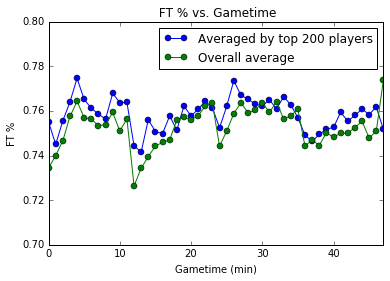

In [21]:
groupedtime = gametimetopshooters.groupby(['gametime'])
groupedtime.agg(np.mean)
plt.plot(groupedtime.agg(np.mean).index,groupedtime.agg(np.mean).ftpct,'-o', label='Averaged by top 200 players')
plt.plot(gametimeresults.gametime, gametimeresults.ftpct, '-o', label='Overall average')
plt.xlim((0,47))
plt.ylim((.7,.8))
plt.title(' FT % vs. Gametime')
plt.xlabel('Gametime (min)')
plt.ylabel('FT %')
plt.legend(loc='best')

The important thing to note from this plot is that the same early quarter phenomenon is present even when we control for who is taking the free throws. For the blue line, we are equally weighting the free throw percentage for the top 200 players at each minute of game time. Even if worse players take more free throws at the beginning of quarters, they will not be weighted more heavily, yet the phenomenon is still present. Also, end-of-game spike in the overall average now seems more likely to be just based on the best shooters taking more shots. Averaging by player, there is even a decrease of around 1% in the last minute. One might hypothesize that this is due to choking, but we need a more controlled analysis to say this with any certainty.

### Effect of years in the league

Though this does not depend on play-by-play data, it will be important to determine if a player's experience affects their free throw shooting percentage. One could consider whether there is a league-wide trend, or whether each player's career can have a trajectory robust enough to be used for prediction. I'll start with the league-wide average by years in the league. 

In [26]:
query = "SELECT years_in_league, SUM(ft)/SUM(fta) as ftpct, SUM(fta) as allfts FROM seasonwithcareer as swc  \
WHERE swc.playerid IN (SELECT playerid FROM allpbpfts GROUP BY playerid ORDER BY count(result) DESC LIMIT  200)\
GROUP BY years_in_league ORDER BY years_in_league ASC"
byYears = psql.read_sql(query,conn)

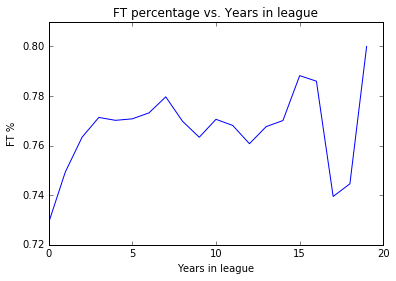

In [25]:
plt.plot(byYears.years_in_league,byYears.ftpct)
plt.title('FT percentage vs. Years in league')
plt.ylabel('FT %')
plt.xlabel('Years in league')

In [30]:
byYears.tail()

,years_in_league,ftpct,allfts
15,15,0.788209,3579
16,16,0.785972,3607
17,17,0.739491,1808
18,18,0.744589,693
19,19,0.800000,45


As we see, there is a 4% increase in free throw percentage between the first and fourth years in the league, but not much change after that. The volatility at high number of years in the league reflects how there are only a few players who last that long.

In [52]:
query = "SELECT playerid, years_in_league, 100*SUM(ft)/SUM(fta) as ftpct, SUM(fta) as allfts FROM seasonwithcareer as swc  \
WHERE swc.playerid IN (SELECT playerid FROM allpbpfts GROUP BY playerid ORDER BY count(result) DESC LIMIT  10)\
GROUP BY playerid, years_in_league ORDER BY playerid, years_in_league ASC"
byPlayer = psql.read_sql(query,conn)

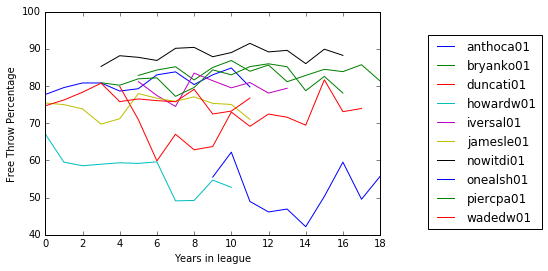

In [53]:
for playerid in byPlayer.playerid.unique():
    plt.plot(byPlayer.years_in_league[byPlayer.playerid==playerid],byPlayer.ftpct[byPlayer.playerid==playerid], label=playerid)
    
plt.legend(bbox_to_anchor=(1.5, 0), loc=4)
plt.ylabel('Free Throw Percentage')
plt.xlabel('Years in league')

We can see that free throw percentage over years in the league doesn't change much for most players. However, it could still be useful for some players. Particularly Dwight Howard (`howardw01`) has had a decreasing free throw percentage for most years in his career.

### Effect of free throw number

One thing that we saw in the gametime exploration was that it seems like players get warmed up over time. They tend to shoot worse in the first few minutes of each quarter, even when controlling for quality of the free throw shooter. This suggests that players may need time to warm up in any given trip to the line. To examine if there is an effect, I'll calculate the free throw percentage by free throw number (1,2, or 3 depending on how many free throws are awarded). I'll also remove technical free throws as they would result in better players shooting more first free throws.

In [13]:
query = "SELECT 100*SUM(result)/COUNT(result) as FTpct, 100*SUM(ytd_ftpct)/COUNT(result) as Shooterpct\
        FROM allpbpfts WHERE tech=0 GROUP BY ftnumber"
byFTnumber = psql.read_sql(query,conn)
byFTnumber.index = ['First FT', 'Second FT', 'Third FT']
byFTnumber

,ftpct,shooterpct
First FT,73.170134,74.643450
Second FT,77.787831,74.891293
Third FT,85.170068,80.935177


As we see here, free throw percentage increases significantly with free throw number. The 4.6% difference between first and second free throws is bigger than any effect explored thus far. I speculated that the average quality of shooter could be different between the different free throw numbers and thus kept track of that as `shooterpct`. It turns out that there is only much of a difference for third free throws. This makes sense as only three point shooters have a chance for three free throws and they tend to be better shooters.

## Free Throw Prediction

### Obeying the flow of time

In designing a sensible tool for prediction free throw percentage, we have to come up with a model that is not trained using any future data, even though it may be in our database. This means that we will have very little information on an individual at the beginning of their rookie season, but we will gain data and incorporate it to make better predictions over time.

In the exploration above, we find that there are league-wide trends based on free throw number, score differential, and venue, but each individual has their own trends too. The best model will probably rely more on league trends when the player has few attempts on record and then become more personalized as the data comes in. With this in mind, let's make an example dataset with all the free throws from LeBron James to train a model.

In [29]:
query = "SELECT date, gametime, CASE WHEN teamha='H' THEN 1 ELSE 0 END as ishome, score_diff, ftnumber, tech, attempts_to_date, \
CASE WHEN (attempts_to_date>=100 OR ctd_ftpct IS NULL) THEN ytd_ftpct ELSE ctd_ftpct END as ftpct, years_in_league, result \
FROM (allpbpfts as pbp JOIN allgames ON pbp.gameid=allgames.gameid) \
JOIN seasonwithcareer as swc ON pbp.playerid=swc.playerid AND allgames.season=swc.year \
WHERE pbp.playerid='jamesle01' ORDER BY years_in_league ASC, attempts_to_date ASC"
lebronFTs = psql.read_sql(query,conn)

In [30]:
lebronFTsX, lebronFTsY = lebronFTs.ix[:,:-1], lebronFTs.ix[:,-1]
X_train, X_toPredict, Y_train, Y_toPredict = train_test_split(lebronFTsX, lebronFTsY, test_size=0.1, random_state=8)

### The log loss metric

It is important to consider the metric used to evaluate a predicted free throw percentage. Since the result of a given attempt is always going to be 0 or 1, a perfect estimate of the free throw percentage will not label any free throws correctly. The purpose of the log loss metric is that it penalizes predictions based on how far they were from the actual result. The loss function is,
$$logloss=-\frac{1}{N}\sum_{i=1}^N(y_ilog(p_i)+(1-y_i)log(1-p_i)$$
This loss function is unbiased in that the correct free throw percentage will minimize the loss function over a large sample.

In [14]:
def logloss(actual, pred):
    epsilon = 1e-15
    pred = scipy.maximum(epsilon, pred) #buffer from 0 so that the log loss isn't infinite
    pred = scipy.minimum(1-epsilon, pred)
    logl = sum(actual*scipy.log(pred) + scipy.subtract(1,actual)*scipy.log(scipy.subtract(1,pred)))
    logl = logl * -1.0/len(actual)
    return logl

### Feature standardization

It is important to make sure that the features are standardized for many machine learning algorithms. In some cases, particularly that include Euclidean distance, features with smaller variance will be weighted more strongly. In other cases, like algorithms using stochastic gradient descent, non-standardized features will lead to convergence problems as partial derivatives can be on different scales.

To do the standardization, I will first subtract off the mean of the feature and then divide by twice the standard deviation. This may seem unorthodox, but it enables better standardization when there are also binary variables. This is because a balanced binary variable has a standard deviation of 0.5 . For more on this, check out [www.stat.columbia.edu/~gelman/research/unpublished/standardizing.pdf](http://www.stat.columbia.edu/~gelman/research/unpublished/standardizing.pdf)

In [22]:
toStandardize = ['gametime', 'score_diff', 'ftnumber','attempts_to_date', 'ftpct', 'years_in_league']
scalers = [StandardScaler()]*len(toStandardize)
scaled = [None]*len(toStandardize)
scaled_X_train = X_train
scaled_X_toPredict = X_toPredict
for i, column in enumerate(toStandardize):
    scalers[i].fit_transform(scaled_X_train[column])
    scalers[i].transform(scaled_X_toPredict[column])

Technically, feature standardization is not necessary for the random forest model demonstrated below. Since each split in the decision tree is made with respect to a single feature, their relative mean and standard deviation are not important. However, I went through a tremendous number of other models tested through cross validation. Many of those, particularly regularized regression and SVMs require standardization as the sum of coefficients is considered. As there is a sum, we need to be able to treat the coefficients on equal footing so the features must be standardized.

### Making predictions

As a test of the usefulness of this data, I'll demonstrate prediction for Lebron James. This is nice in that he has shot a lot of free throws and his career falls nicely within our range of data, but his free throw shooting is seemingly similar to NBA players as a whole.

In [33]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=3)
pbar = ProgressBar.ProgressBar(X_toPredict.shape[0])
predrfc = np.empty(X_toPredict.shape[0])
predBaseline = np.empty(X_toPredict.shape[0])

for i, shot in enumerate(X_toPredict.iterrows()):
    shot = shot[1]
    forPrediction = lebronFTs[(lebronFTs.years_in_league < shot.years_in_league) | ((lebronFTs.years_in_league == shot.years_in_league) & (lebronFTs.attempts_to_date < shot.attempts_to_date))]
    if forPrediction.shape[0]!=0:
        forPredictionX, forPredictionY = forPrediction.ix[:,1:-1], forPrediction.ix[:,-1]
        rfc.fit(forPredictionX, forPredictionY)
        if rfc.n_classes_==2:
            predrfc[i] = rfc.predict_proba(shot.ix[1:])[0][1]
        else:
            predrfc[i] = rfc.classes_
    else:
        predrfc[i] = shot.ftpct
        
    predBaseline[i] = shot.ftpct
    pbar.increment()
pbar.finish()

Complete! Total Elapsed time: 193.6 seconds                        


In [34]:
print('Baseline log loss: ' + str(logloss(Y_toPredict.values,predBaseline)))
print('Random Forest log loss: ' + str(logloss(Y_toPredict.values,predrfc)))

Baseline log loss: 0.554204921204
Random Forest log loss: 0.552256139082


## Conclusion

As we can see, using the Random Forest Classifier that incorporates play-by-play data can reduce the log loss, thus indicating a better prediction. It is not immediately obvious how to translate the log loss score to a certain percent better accuracy. In fact, this conversion depends on knowing the actual free throw percentage of the population. 

As an example, we can generate a random set of free throws with a certain percentage of makes. Then, we can calculate the log loss of a predictor that perfectly predicts the generating percentage, but not the individual makes or misses. By doing this, we can see that for a 50% shooter, the best log loss would be -ln(.5)=.693 . Free throw shooters of 70% or 80% would have log loss scores more like .5 or .4 . Once the perfect percentage prediction log loss is calculated for a given make percentage, we can calculate the log loss for imperfect percentage predictions. By this means, we can calculate the percent error in our prediction that leads to the log loss difference between the play-by-play model and the baseline. 

In the case above, the prediction accuracy is improved by 2-3% by using play-by-play data. Even though this model is far from optimized and there is much more feature engineering possible with more work, this scale of improvement could already lead to different decisions in game.

## Future directions

The example shown above is representative of how the play-by-play data informs a model for free throw percentage. However, there may be significant room to improve prediction for shooters with few data points. In this case, we would have to take a collaborative approach and see what can be gained from shooters as a whole to inform the shooter with less data. In general, combining the league behavior that has little variance with the individual behavior that has high variance but low bias could lead to good results.